# Random Forest Model with Rolling Origin Evaluation (ROE)

Given that the task is to predict next month(s) fire risk, here we use Rolling Origin Evaluation (ROE) to:
1. Simulate realistic month-ahead forecasting
2. Evaluate model performance across multiple prediction horizons  
3. Generate true future predictions for October 2025 and beyond

So, basically, instead of a single train-test split, we:
- Start with an initial training window (2005-09 to 2020-12)
- Tune hyperparameters on a separate validation period (2019-2020)
- Predict the next month (2021-01) using data up to 2020-12
- Expand the training window by 1 month
- Predict the next month (2021-02) using data up to 2021-01
- Repeat until we reach September 2025
- Make final prediction for October 2025

## Some benefits of ROE over basic/static RF model
- **Realistic evaluation**: Here, we mimic how the model would be used in production
- **Multiple predictions**: Tests model stability across time
- **True forecasting**: Generates future predictions
- **Detects concept drift**: Shows if model performance degrades over time

## Imports and Data Loading

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import box
from shapely.ops import unary_union
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score,
    precision_score, recall_score, f1_score,
    accuracy_score, balanced_accuracy_score
)
from datetime import datetime
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Plot
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

In [2]:
pwd

'/content'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Set wd
#%cd "/content/drive/MyDrive/MCGILL_PROJECT_CAPSTONE/Capstone Project- McGill/Data/"
#%cd "/content/drive/MyDrive/Capstone Project- McGill/Data/"
%cd "/content/drive/MyDrive/Sam_McGill_Project_Team3"

#os.chdir("/mnt/g/My Drive/Capstone Project- McGill")
print(f"Working directory: {os.getcwd()}")

/content/drive/MyDrive/Sam_McGill_Project_Team3
Working directory: /content/drive/MyDrive/Sam_McGill_Project_Team3


#### Please note this was based on the 5km grid. Please replace the data here with the final version generated using the team's code (which is based on 2.5km grid we agreed on). The same logic applies, only the data will need to be changed- select the right data below.

In [5]:
# Load the data
#df = pd.read_parquet('Data/fire_risk_panel_data.parquet') #you could use the csv version if preferred
df = pd.read_parquet('fire_risk_panel_data_201025.parquet') #you could use the csv version if preferred

print(f"Dataset loaded: {df.shape[0]:,} rows x {df.shape[1]} columns")
print(f"Date range: {df['year_month'].min()} to {df['year_month'].max()}")
print(f"Unique cells: {df['cell_id'].nunique()}")
print(f"Target distribution:")
print(df['Target_Variable'].value_counts(normalize=True))

df.head()

Dataset loaded: 27,715 rows x 23 columns
Date range: 2005-09 to 2025-09
Unique cells: 115
Target distribution:
Target_Variable
1    0.831788
0    0.168212
Name: proportion, dtype: float64


,cell_id,year_month,number_of_fires,num_buildings,avg_floors,median_construction_year,Target_Variable,fires_lag_1m,fires_lag_2m,fires_lag_3m,...,target_lag_2m,target_lag_3m,month,year,month_sin,month_cos,neighbors_fires_lag1m,neighbors_target_lag1m,neighbor_count,neighbors_fires_avg
0,0_1,2005-09,1.0,37.0,1.378378,1953.0,1,0.0,0.0,0.0,...,0.0,0.0,9,2005,-1.000000e+00,-1.836970e-16,0.0,0,1,0.0
1,0_1,2005-10,1.0,37.0,1.378378,1953.0,1,1.0,0.0,0.0,...,0.0,0.0,10,2005,-8.660254e-01,5.000000e-01,3.0,1,1,3.0
2,0_1,2005-11,0.0,37.0,1.378378,1953.0,0,1.0,1.0,0.0,...,1.0,0.0,11,2005,-5.000000e-01,8.660254e-01,3.0,1,1,3.0
3,0_1,2005-12,0.0,37.0,1.378378,1953.0,0,0.0,1.0,1.0,...,1.0,1.0,12,2005,-2.449294e-16,1.000000e+00,4.0,1,1,4.0
4,0_1,2006-01,0.0,37.0,1.378378,1953.0,0,0.0,0.0,1.0,...,0.0,1.0,1,2006,5.000000e-01,8.660254e-01,4.0,1,1,4.0


## Feature Selection

In [6]:
# Feature sets
BUILDING_FEATURES = ['num_buildings', 'avg_floors', 'median_construction_year']

TEMPORAL_LAG_FEATURES = [
    'fires_lag_1m', 'fires_lag_2m', 'fires_lag_3m', 'fires_lag_6m', 'fires_lag_12m',
    'target_lag_1m', 'target_lag_2m', 'target_lag_3m'
]

SEASONALITY_FEATURES = ['month', 'year', 'month_sin', 'month_cos']

SPATIAL_LAG_FEATURES = [
    'neighbors_fires_lag1m', 'neighbors_target_lag1m',
    'neighbor_count', 'neighbors_fires_avg'
]

# All predictors
PREDICTOR_FEATURES = (
    BUILDING_FEATURES +
    TEMPORAL_LAG_FEATURES +
    SEASONALITY_FEATURES +
    SPATIAL_LAG_FEATURES
)

TARGET = 'Target_Variable'

print(f"Total predictors: {len(PREDICTOR_FEATURES)}")
print(f"All predictors:")
for i, feat in enumerate(PREDICTOR_FEATURES, 1):
    print(f"  {i:2d}. {feat}")

Total predictors: 19
All predictors:
   1. num_buildings
   2. avg_floors
   3. median_construction_year
   4. fires_lag_1m
   5. fires_lag_2m
   6. fires_lag_3m
   7. fires_lag_6m
   8. fires_lag_12m
   9. target_lag_1m
  10. target_lag_2m
  11. target_lag_3m
  12. month
  13. year
  14. month_sin
  15. month_cos
  16. neighbors_fires_lag1m
  17. neighbors_target_lag1m
  18. neighbor_count
  19. neighbors_fires_avg


In [7]:
# Leaving this here on how to remove rows with missing lagged values
# In the group's codebase (using 2.5km by 2.5km grid), we may have missing values- although not applicable here.
# This ensures we only train on complete observations

df_clean = df.dropna(subset=PREDICTOR_FEATURES)

print(f"Original data: {len(df):,} rows")
print(f"After removing NaNs: {len(df_clean):,} rows")
print(f"Removed: {len(df) - len(df_clean):,} rows")

# Convert year_month to datetime for easier manipulation
df_clean['year_month_dt'] = pd.to_datetime(df_clean['year_month'])
df_clean = df_clean.sort_values(['cell_id', 'year_month_dt'])

print(f"Date range: {df_clean['year_month'].min()} to {df_clean['year_month'].max()}")

Original data: 27,715 rows
After removing NaNs: 27,715 rows
Removed: 0 rows
Date range: 2005-09 to 2025-09


## Exploratory Data Analysis

In [8]:
X_all = df_clean[PREDICTOR_FEATURES]
X_all.head()

,num_buildings,avg_floors,median_construction_year,fires_lag_1m,fires_lag_2m,fires_lag_3m,fires_lag_6m,fires_lag_12m,target_lag_1m,target_lag_2m,target_lag_3m,month,year,month_sin,month_cos,neighbors_fires_lag1m,neighbors_target_lag1m,neighbor_count,neighbors_fires_avg
0,37.0,1.378378,1953.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9,2005,-1.000000e+00,-1.836970e-16,0.0,0,1,0.0
1,37.0,1.378378,1953.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,10,2005,-8.660254e-01,5.000000e-01,3.0,1,1,3.0
2,37.0,1.378378,1953.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,11,2005,-5.000000e-01,8.660254e-01,3.0,1,1,3.0
3,37.0,1.378378,1953.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,12,2005,-2.449294e-16,1.000000e+00,4.0,1,1,4.0
4,37.0,1.378378,1953.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1,2006,5.000000e-01,8.660254e-01,4.0,1,1,4.0


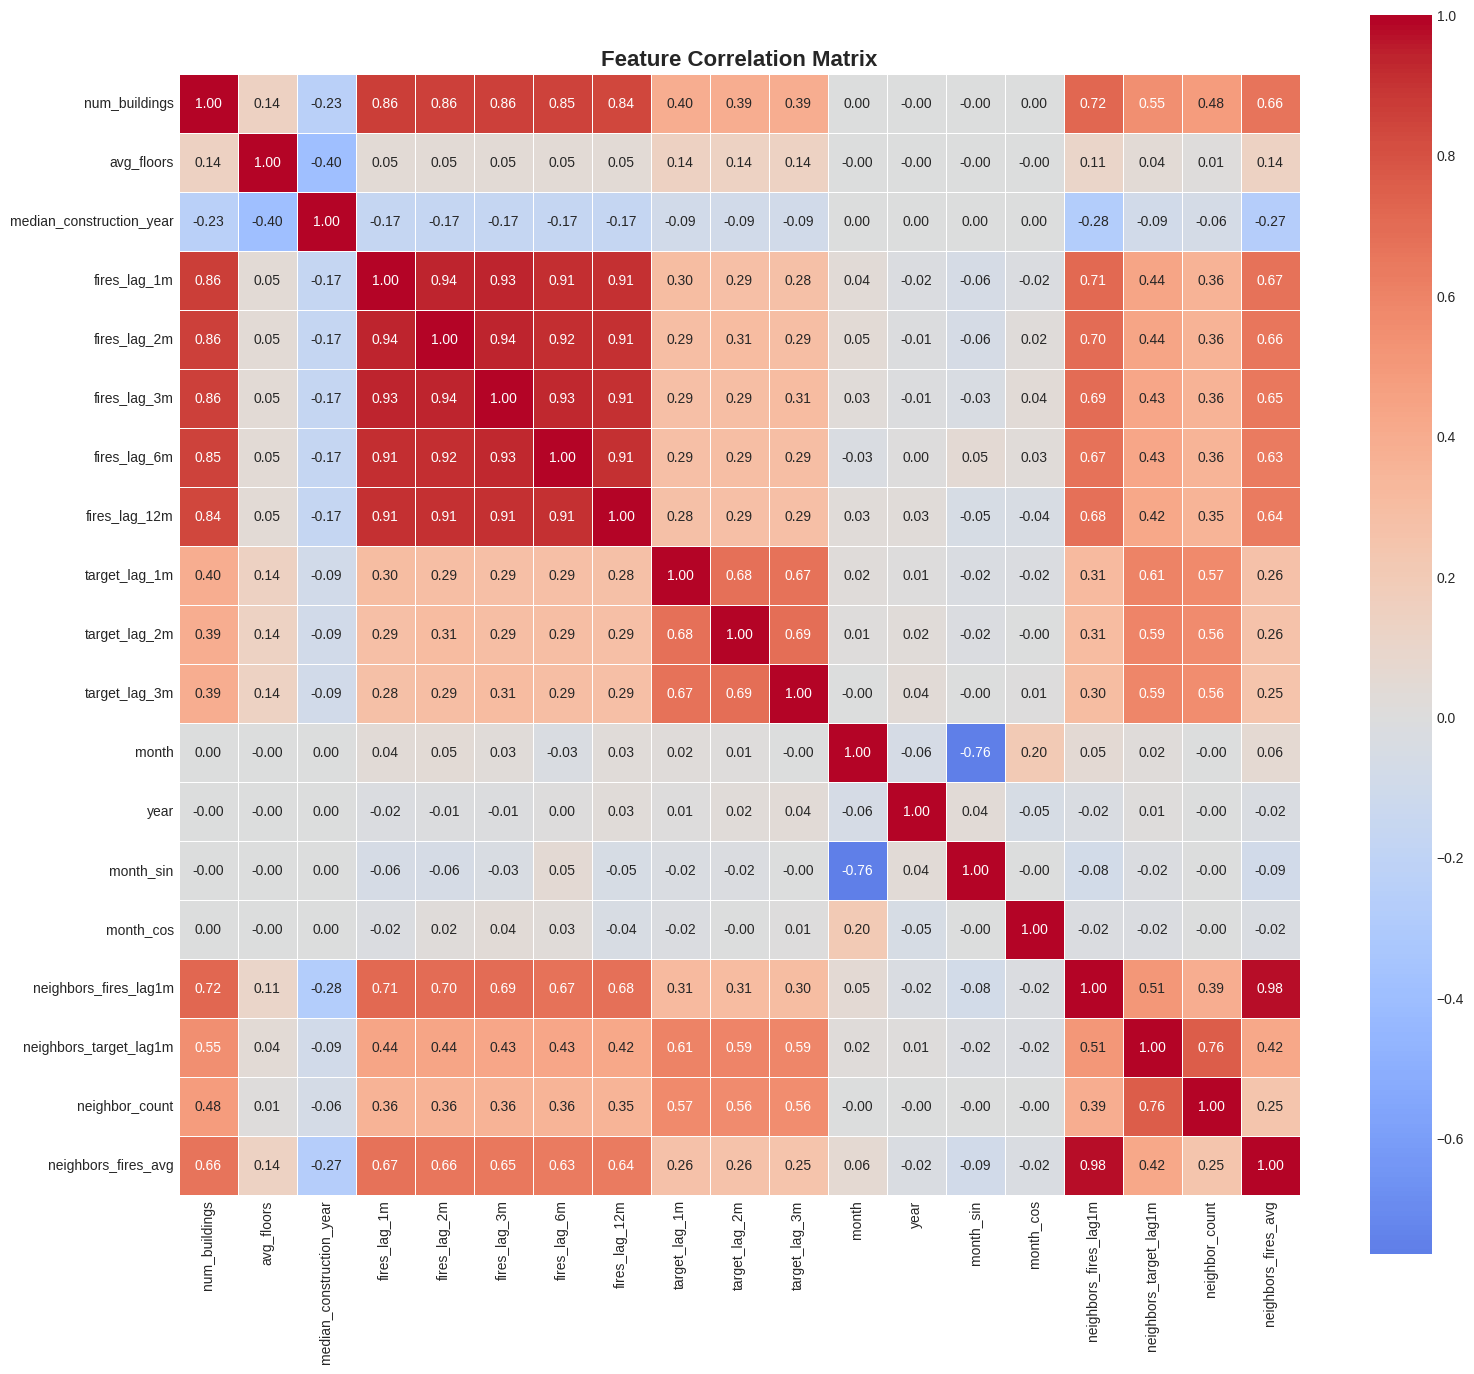


Highly correlated features (|r| > 0.8):
  num_buildings <-> fires_lag_1m: 0.863
  num_buildings <-> fires_lag_2m: 0.861
  num_buildings <-> fires_lag_3m: 0.858
  num_buildings <-> fires_lag_6m: 0.851
  num_buildings <-> fires_lag_12m: 0.836
  fires_lag_1m <-> fires_lag_2m: 0.944
  fires_lag_1m <-> fires_lag_3m: 0.935
  fires_lag_1m <-> fires_lag_6m: 0.913
  fires_lag_1m <-> fires_lag_12m: 0.907
  fires_lag_2m <-> fires_lag_3m: 0.944
  fires_lag_2m <-> fires_lag_6m: 0.917
  fires_lag_2m <-> fires_lag_12m: 0.908
  fires_lag_3m <-> fires_lag_6m: 0.926
  fires_lag_3m <-> fires_lag_12m: 0.907
  fires_lag_6m <-> fires_lag_12m: 0.908
  neighbors_fires_lag1m <-> neighbors_fires_avg: 0.978


In [10]:
# Correlation matrix
corr_matrix = X_all.corr()

plt.figure(figsize=(16, 14))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, square=True, linewidths=0.5)
plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Identify highly correlated features (threshold |r| > 0.8)
high_corr = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.8:
            high_corr.append((
                corr_matrix.columns[i],
                corr_matrix.columns[j],
                corr_matrix.iloc[i, j]
            ))

if high_corr:
    print("\nHighly correlated features (|r| > 0.8):")
    for feat1, feat2, corr in high_corr:
        print(f"  {feat1} <-> {feat2}: {corr:.3f}")
else:
    print("\nNo highly correlated features found (|r| > 0.8)")

## Rolling Origin Evaluation

In [12]:
# ROE config
#Here, we define the ROE params, we can decide to shift the dates as needed, but just make sure you avoid data leakage (especially since we will tune the hyperparameter- see below cell).
INITIAL_TRAIN_END = '2022-08'  # Initial training period ends
EVALUATION_START = '2022-09'   # Start making predictions from this month
EVALUATION_END = '2025-09'     # Last observed month
FUTURE_PREDICT = '2025-10'     # Future month to predict

# Get list of all months to predict in ROE
all_months = sorted(df_clean['year_month'].unique())
eval_months = [m for m in all_months if m >= EVALUATION_START and m <= EVALUATION_END]

print("Rolling Origin Evaluation Configuration:")
print(f"  Initial training period: {df_clean['year_month'].min()} to {INITIAL_TRAIN_END}")
print(f"  Evaluation period: {EVALUATION_START} to {EVALUATION_END}")
print(f"  Number of rolling predictions: {len(eval_months)}")
print(f"  Future prediction target: {FUTURE_PREDICT}")
print(f"  First 5 prediction months: {eval_months[:5]}")
print(f"  Last 5 prediction months: {eval_months[-5:]}")

Rolling Origin Evaluation Configuration:
  Initial training period: 2005-09 to 2022-08
  Evaluation period: 2022-09 to 2025-09
  Number of rolling predictions: 37
  Future prediction target: 2025-10
  First 5 prediction months: ['2022-09', '2022-10', '2022-11', '2022-12', '2023-01']
  Last 5 prediction months: ['2025-05', '2025-06', '2025-07', '2025-08', '2025-09']


## Hyperparameter Tuning

Here, we tune hyperparameters on a holdout period (2021-2022) before running ROE evaluation.

In [13]:
# Validation set for hyperparameter tuning

TUNE_TRAIN_END = '2021-12'
TUNE_VAL_START = '2022-01'
TUNE_VAL_END = '2022-12'

tune_train_data = df_clean[df_clean['year_month'] <= TUNE_TRAIN_END]
tune_val_data = df_clean[(df_clean['year_month'] >= TUNE_VAL_START) &
                          (df_clean['year_month'] <= TUNE_VAL_END)]

X_tune_train = tune_train_data[PREDICTOR_FEATURES]
y_tune_train = tune_train_data[TARGET]
X_tune_val = tune_val_data[PREDICTOR_FEATURES]
y_tune_val = tune_val_data[TARGET]

print("Hyperparameter Tuning Data Split:")
print(f"  Tuning train set: {len(tune_train_data):,} observations ({tune_train_data['year_month'].min()} to {TUNE_TRAIN_END})")
print(f"  Tuning validation set: {len(tune_val_data):,} observations ({TUNE_VAL_START} to {TUNE_VAL_END})")
print(f"  Train fire rate: {y_tune_train.mean():.2%}")
print(f"  Validation fire rate: {y_tune_val.mean():.2%}")

Hyperparameter Tuning Data Split:
  Tuning train set: 22,540 observations (2005-09 to 2021-12)
  Tuning validation set: 1,380 observations (2022-01 to 2022-12)
  Train fire rate: 83.33%
  Validation fire rate: 81.59%


### Randomized Search with Time Series Cross-Validation

In [15]:
# Parameter distributions for randomized search
param_distributions = {
    'n_estimators': [100, 150, 200, 250, 300],
    'max_depth': [10, 15, 20, 25, 30, None],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6],
    'max_features': ['sqrt', 'log2', 0.5, 0.7]
}

print("Parameter distributions for randomized search:")
for param, values in param_distributions.items():
    print(f"  {param}: {values}")

# Time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

print(f"Performing randomized search with {tscv.n_splits} CV folds...")
print("Testing 30 random combinations (may take some time)...")

rf_random = RandomForestClassifier(
    random_state=RANDOM_STATE,
    class_weight='balanced',   # Handles class imbalance
    n_jobs=-1
)

random_search = RandomizedSearchCV(
    estimator=rf_random,
    param_distributions=param_distributions,
    n_iter=30,  # Number of random combinations to try
    cv=tscv,
    scoring='f1',
    n_jobs=-1,
    verbose=2,
    random_state=RANDOM_STATE,
    return_train_score=True
)

random_search.fit(X_tune_train, y_tune_train)

# Extract best parameters
BEST_PARAMS = random_search.best_params_
BEST_PARAMS['class_weight'] = 'balanced'
BEST_PARAMS['random_state'] = RANDOM_STATE
BEST_PARAMS['n_jobs'] = -1

print("Randomized search complete!")
print(f"Best parameters found:")
for param, value in BEST_PARAMS.items():
    print(f"  {param}: {value}")
print(f"Best CV F1-score: {random_search.best_score_:.4f}")

Parameter distributions for randomized search:
  n_estimators: [100, 150, 200, 250, 300]
  max_depth: [10, 15, 20, 25, 30, None]
  min_samples_split: [2, 5, 10, 15]
  min_samples_leaf: [1, 2, 4, 6]
  max_features: ['sqrt', 'log2', 0.5, 0.7]
Performing randomized search with 5 CV folds...
Testing 30 random combinations (may take some time)...
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Randomized search complete!
Best parameters found:
  n_estimators: 250
  min_samples_split: 15
  min_samples_leaf: 6
  max_features: sqrt
  max_depth: 15
  class_weight: balanced
  random_state: 42
  n_jobs: -1
Best CV F1-score: 0.9633


### Validate Best Parameters on Hold-out Set

In [16]:
# Train model with best parameters on tuning train set
print("Validating best parameters on hold-out validation set (2022)...")

rf_best_tuned = RandomForestClassifier(**BEST_PARAMS, verbose=0)
rf_best_tuned.fit(X_tune_train, y_tune_train)

# Predict on validation set
y_val_pred = rf_best_tuned.predict(X_tune_val)
y_val_pred_proba = rf_best_tuned.predict_proba(X_tune_val)[:, 1]

# Evaluate
val_accuracy = accuracy_score(y_tune_val, y_val_pred)
val_balanced_accuracy = balanced_accuracy_score(y_tune_val, y_val_pred)
val_precision = precision_score(y_tune_val, y_val_pred)
val_recall = recall_score(y_tune_val, y_val_pred)
val_f1 = f1_score(y_tune_val, y_val_pred)
val_roc_auc = roc_auc_score(y_tune_val, y_val_pred_proba)

print("Validation Set Performance (2020):")
print("="*80)
print(f"  Accuracy: {val_accuracy:.4f}")
print(f"  Balanced Accuracy: {val_balanced_accuracy:.4f}")
print(f"  Precision: {val_precision:.4f}")
print(f"  Recall: {val_recall:.4f}")
print(f"  F1-Score: {val_f1:.4f}")
print(f"  ROC-AUC: {val_roc_auc:.4f}")

print("="*80)
print("HYPERPARAMETER TUNING COMPLETE")
print("="*80)
print(f"So, now we can use these hyperparameters in the ROE evaluation.")

Validating best parameters on hold-out validation set (2022)...
Validation Set Performance (2020):
  Accuracy: 0.9232
  Balanced Accuracy: 0.9072
  Precision: 0.9722
  Recall: 0.9325
  F1-Score: 0.9519
  ROC-AUC: 0.9703
HYPERPARAMETER TUNING COMPLETE
So, now we can use these hyperparameters in the ROE evaluation.


## Rolling Origin Evaluation Loop

Now we use the tuned hyperparameters for the rolling origin evaluation.

In [17]:
# Init storage for results
roe_results = []
roe_predictions = []

print("Starting Rolling Origin Evaluation...")
print(f"This will train {len(eval_months)} models (one for each prediction month)")
print("Warning- this may take several minutes...\n")

# Progress bar
for target_month in tqdm(eval_months, desc="ROE Progress"):
    # Training data: all data before target_month
    train_data = df_clean[df_clean['year_month'] < target_month]

    # Test data: only the target_month
    test_data = df_clean[df_clean['year_month'] == target_month]

    # Skip if no test data
    if len(test_data) == 0:
        continue

    # Prepare features
    X_train = train_data[PREDICTOR_FEATURES]
    y_train = train_data[TARGET]
    X_test = test_data[PREDICTOR_FEATURES]
    y_test = test_data[TARGET]

    # Train model with tuned hyperparameters
    model = RandomForestClassifier(**BEST_PARAMS, verbose=0)
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Calculate metrics
    metrics = {
        'target_month': target_month,
        'train_size': len(train_data),
        'test_size': len(test_data),
        'train_start': train_data['year_month'].min(),
        'train_end': train_data['year_month'].max(),
        'accuracy': accuracy_score(y_test, y_pred),
        'balanced_accuracy': balanced_accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred, zero_division=0),
        'recall': recall_score(y_test, y_pred, zero_division=0),
        'f1_score': f1_score(y_test, y_pred, zero_division=0),
        'roc_auc': roc_auc_score(y_test, y_pred_proba) if len(y_test.unique()) > 1 else np.nan
    }
    roe_results.append(metrics)

    # Store predictions
    pred_df = test_data[['cell_id', 'year_month']].copy()
    pred_df['actual'] = y_test.values
    pred_df['predicted'] = y_pred
    pred_df['predicted_proba'] = y_pred_proba
    roe_predictions.append(pred_df)

print("\nROE Complete!")
print(f"Total predictions made: {len(roe_results)}")

Starting Rolling Origin Evaluation...
This will train 37 models (one for each prediction month)
Warning- this may take several minutes...



ROE Progress: 100%|██████████| 37/37 [03:40<00:00,  5.97s/it]


ROE Complete!
Total predictions made: 37


## ROE Results Analysis

In [18]:
# Convert results to DataFrame
roe_metrics_df = pd.DataFrame(roe_results)
roe_metrics_df['target_month_dt'] = pd.to_datetime(roe_metrics_df['target_month'])

print("Rolling Origin Evaluation Results Summary:")
print("="*80)
print(f"\nOverall Performance Across All {len(roe_metrics_df)} Predictions:")
print(f"  Mean Accuracy: {roe_metrics_df['accuracy'].mean():.4f} ± {roe_metrics_df['accuracy'].std():.4f}")
print(f"  Mean Balanced Accuracy: {roe_metrics_df['balanced_accuracy'].mean():.4f} ± {roe_metrics_df['balanced_accuracy'].std():.4f}")
print(f"  Mean Precision: {roe_metrics_df['precision'].mean():.4f} ± {roe_metrics_df['precision'].std():.4f}")
print(f"  Mean Recall: {roe_metrics_df['recall'].mean():.4f} ± {roe_metrics_df['recall'].std():.4f}")
print(f"  Mean F1-Score: {roe_metrics_df['f1_score'].mean():.4f} ± {roe_metrics_df['f1_score'].std():.4f}")
print(f"  Mean ROC-AUC: {roe_metrics_df['roc_auc'].mean():.4f} ± {roe_metrics_df['roc_auc'].std():.4f}")

print(f"\nBest Performing Month:")
best_month = roe_metrics_df.loc[roe_metrics_df['f1_score'].idxmax()]
print(f"  Month: {best_month['target_month']}")
print(f"  F1-Score: {best_month['f1_score']:.4f}")

print(f"\nWorst Performing Month:")
worst_month = roe_metrics_df.loc[roe_metrics_df['f1_score'].idxmin()]
print(f"  Month: {worst_month['target_month']}")
print(f"  F1-Score: {worst_month['f1_score']:.4f}")

print("\nFirst 10 predictions:")
print(roe_metrics_df[['target_month', 'accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']].head(10))

Rolling Origin Evaluation Results Summary:

Overall Performance Across All 37 Predictions:
  Mean Accuracy: 0.9295 ± 0.0185
  Mean Balanced Accuracy: 0.9239 ± 0.0327
  Mean Precision: 0.9806 ± 0.0148
  Mean Recall: 0.9332 ± 0.0158
  Mean F1-Score: 0.9562 ± 0.0118
  Mean ROC-AUC: 0.9767 ± 0.0121

Best Performing Month:
  Month: 2025-01
  F1-Score: 0.9890

Worst Performing Month:
  Month: 2022-12
  F1-Score: 0.9326

First 10 predictions:
  target_month  accuracy  precision    recall  f1_score   roc_auc
0      2022-09  0.939130   0.978261  0.947368  0.962567  0.982105
1      2022-10  0.939130   0.988764  0.936170  0.961749  0.967072
2      2022-11  0.939130   0.988636  0.935484  0.961326  0.975562
3      2022-12  0.895652   0.954023  0.912088  0.932584  0.961996
4      2023-01  0.895652   0.954545  0.913043  0.933333  0.967864
5      2023-02  0.904348   0.988372  0.894737  0.939227  0.970526
6      2023-03  0.939130   0.977778  0.946237  0.961749  0.959433
7      2023-04  0.930435   0.989

## Visualize ROE Performance Over Time

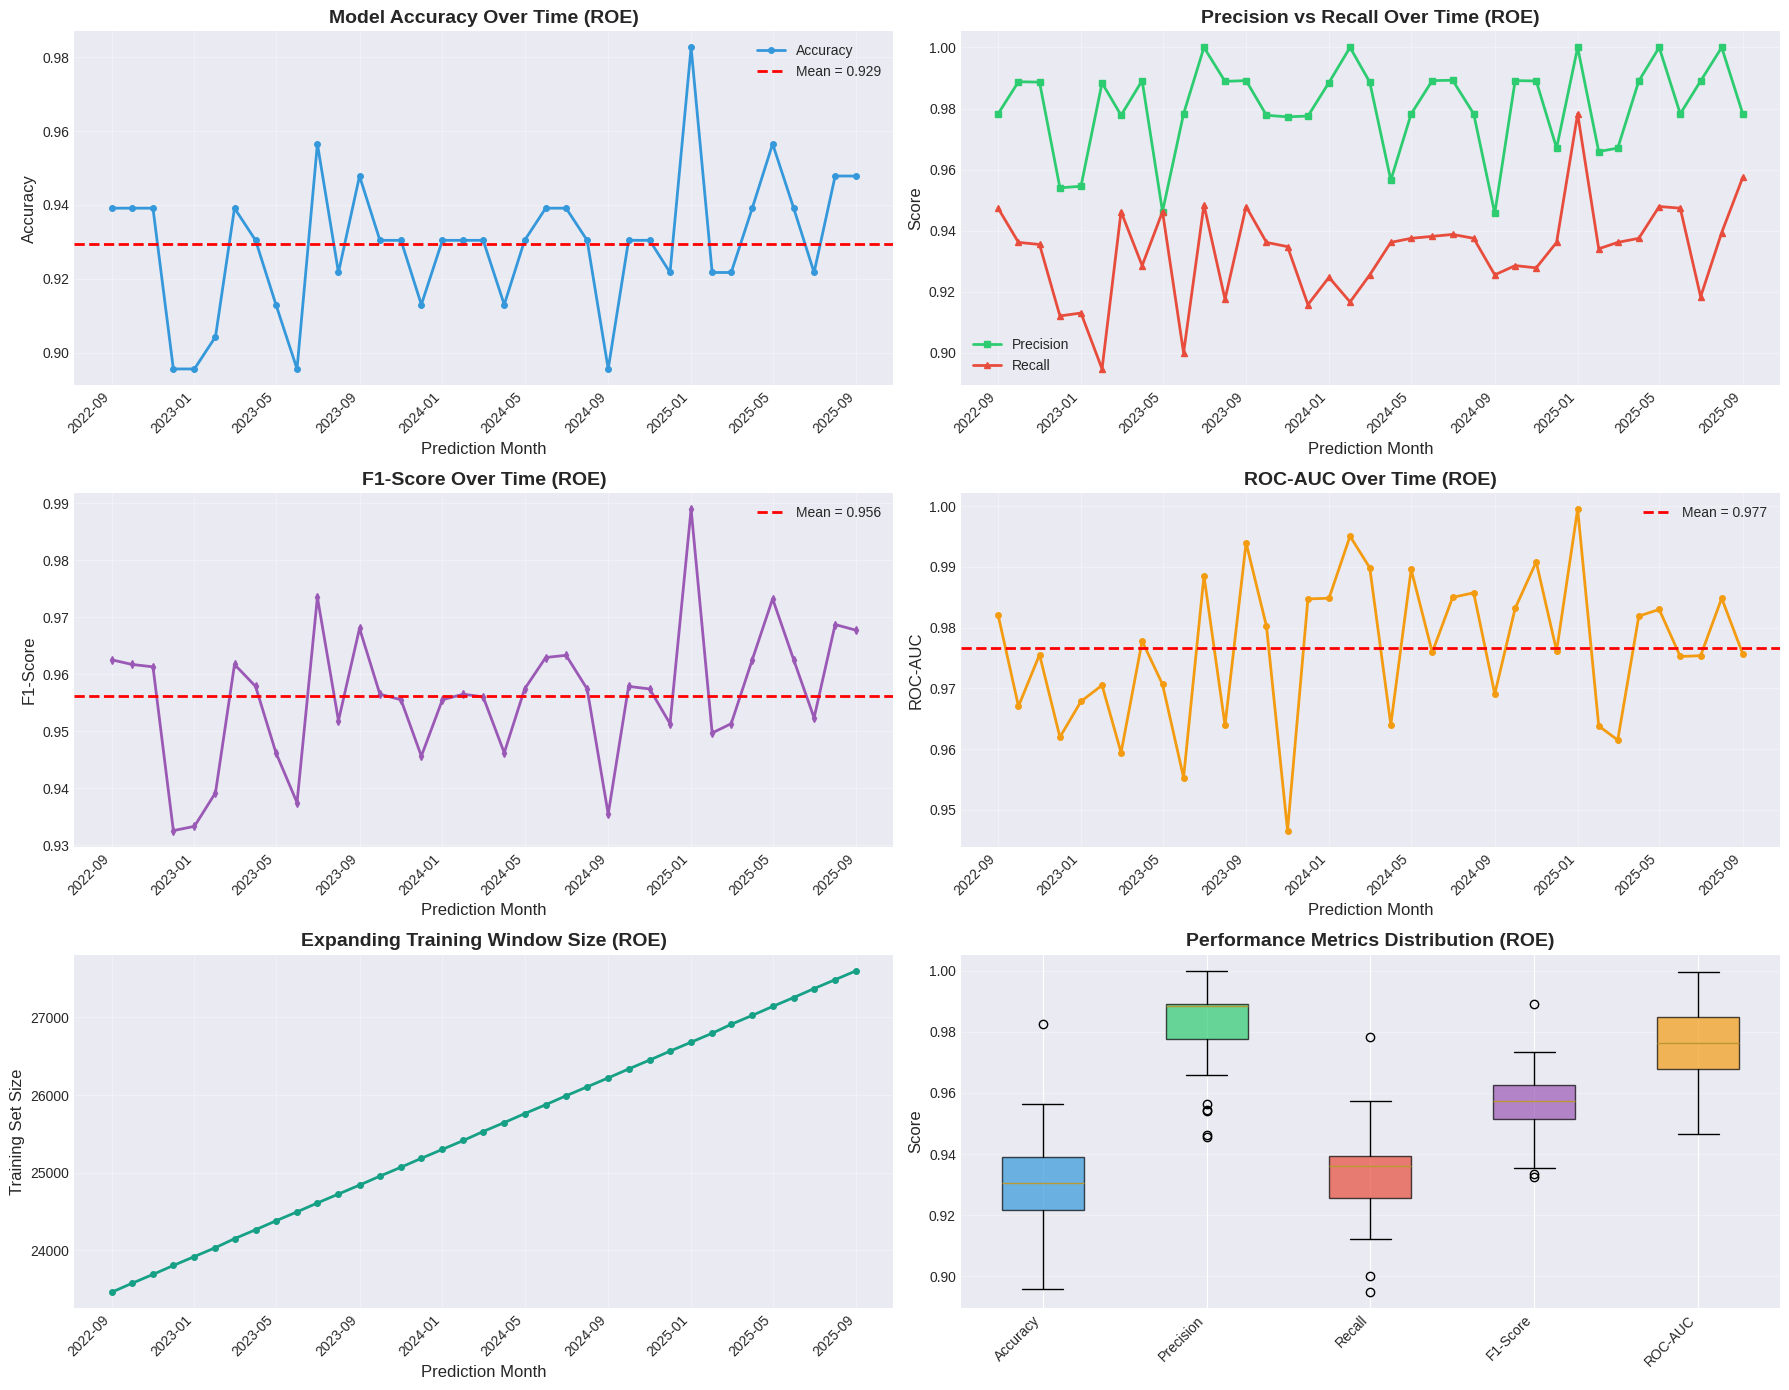

In [19]:

fig, axes = plt.subplots(3, 2, figsize=(18, 14))

# Accuracy over time
ax1 = axes[0, 0]
ax1.plot(roe_metrics_df['target_month_dt'], roe_metrics_df['accuracy'],
         marker='o', linewidth=2, markersize=4, color='#3498db', label='Accuracy')
ax1.axhline(y=roe_metrics_df['accuracy'].mean(), color='red', linestyle='--',
           linewidth=2, label=f"Mean = {roe_metrics_df['accuracy'].mean():.3f}")
ax1.set_xlabel('Prediction Month', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.set_title('Model Accuracy Over Time (ROE)', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Precision and Recall
ax2 = axes[0, 1]
ax2.plot(roe_metrics_df['target_month_dt'], roe_metrics_df['precision'],
         marker='s', linewidth=2, markersize=4, color='#2ecc71', label='Precision')
ax2.plot(roe_metrics_df['target_month_dt'], roe_metrics_df['recall'],
         marker='^', linewidth=2, markersize=4, color='#e74c3c', label='Recall')
ax2.set_xlabel('Prediction Month', fontsize=12)
ax2.set_ylabel('Score', fontsize=12)
ax2.set_title('Precision vs Recall Over Time (ROE)', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)
plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')

# F1-Score
ax3 = axes[1, 0]
ax3.plot(roe_metrics_df['target_month_dt'], roe_metrics_df['f1_score'],
         marker='d', linewidth=2, markersize=4, color='#9b59b6')
ax3.axhline(y=roe_metrics_df['f1_score'].mean(), color='red', linestyle='--',
           linewidth=2, label=f"Mean = {roe_metrics_df['f1_score'].mean():.3f}")
ax3.set_xlabel('Prediction Month', fontsize=12)
ax3.set_ylabel('F1-Score', fontsize=12)
ax3.set_title('F1-Score Over Time (ROE)', fontsize=14, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45, ha='right')

# ROC-AUC
ax4 = axes[1, 1]
ax4.plot(roe_metrics_df['target_month_dt'], roe_metrics_df['roc_auc'],
         marker='o', linewidth=2, markersize=4, color='#f39c12')
ax4.axhline(y=roe_metrics_df['roc_auc'].mean(), color='red', linestyle='--',
           linewidth=2, label=f"Mean = {roe_metrics_df['roc_auc'].mean():.3f}")
ax4.set_xlabel('Prediction Month', fontsize=12)
ax4.set_ylabel('ROC-AUC', fontsize=12)
ax4.set_title('ROC-AUC Over Time (ROE)', fontsize=14, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)
plt.setp(ax4.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Training set size
ax5 = axes[2, 0]
ax5.plot(roe_metrics_df['target_month_dt'], roe_metrics_df['train_size'],
         marker='o', linewidth=2, markersize=4, color='#16a085')
ax5.set_xlabel('Prediction Month', fontsize=12)
ax5.set_ylabel('Training Set Size', fontsize=12)
ax5.set_title('Expanding Training Window Size (ROE)', fontsize=14, fontweight='bold')
ax5.grid(True, alpha=0.3)
plt.setp(ax5.xaxis.get_majorticklabels(), rotation=45, ha='right')

# Performance distribution
ax6 = axes[2, 1]
metrics_to_plot = roe_metrics_df[['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']]
bp = ax6.boxplot([metrics_to_plot[col].dropna() for col in metrics_to_plot.columns],
                  labels=['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC'],
                  patch_artist=True)
colors = ['#3498db', '#2ecc71', '#e74c3c', '#9b59b6', '#f39c12']
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
ax6.set_ylabel('Score', fontsize=12)
ax6.set_title('Performance Metrics Distribution (ROE)', fontsize=14, fontweight='bold')
ax6.grid(True, alpha=0.3, axis='y')
plt.setp(ax6.xaxis.get_majorticklabels(), rotation=45, ha='right')

plt.tight_layout()
plt.show()

## Predict October 2025

In [20]:
print("="*80)
print("PREDICTING OCTOBER 2025 (Next Month FORECAST)")
print("="*80)

# We can use September 2025 data to create October features
sept_2025 = df_clean[df_clean['year_month'] == '2025-09'].copy()

print(f"\nFound {len(sept_2025)} cells with September 2025 data")
print("Creating October 2025 features...")

# October 2025 data
oct_2025 = sept_2025.copy()
oct_2025['year_month'] = '2025-10'
oct_2025['year_month_dt'] = pd.to_datetime('2025-10-01')
oct_2025['month'] = 10
oct_2025['year'] = 2025
oct_2025['month_sin'] = np.sin(2 * np.pi * 10 / 12)
oct_2025['month_cos'] = np.cos(2 * np.pi * 10 / 12)

# Update lag features (shift by 1 month)
oct_2025['fires_lag_1m'] = sept_2025['number_of_fires'].values
oct_2025['fires_lag_2m'] = sept_2025['fires_lag_1m'].values
oct_2025['fires_lag_3m'] = sept_2025['fires_lag_2m'].values
oct_2025['fires_lag_6m'] = sept_2025['fires_lag_3m'].values  # Approximation
oct_2025['fires_lag_12m'] = sept_2025['fires_lag_6m'].values  # Approximation

oct_2025['target_lag_1m'] = sept_2025['Target_Variable'].values
oct_2025['target_lag_2m'] = sept_2025['target_lag_1m'].values
oct_2025['target_lag_3m'] = sept_2025['target_lag_2m'].values

# Spatial lags (using September's neighbor fires)
oct_2025['neighbors_fires_lag1m'] = sept_2025['number_of_fires'].values
oct_2025['neighbors_target_lag1m'] = sept_2025['Target_Variable'].values

print("\nOctober 2025 features created successfully")
print(f"October 2025 observations: {len(oct_2025)}")

PREDICTING OCTOBER 2025 (Next Month FORECAST)

Found 115 cells with September 2025 data
Creating October 2025 features...

October 2025 features created successfully
October 2025 observations: 115


In [21]:
# Train final model on ALL data up to September 2025
print("\nTraining final model on all data up to September 2025...")

train_final = df_clean[df_clean['year_month'] <= '2025-09']
X_train_final = train_final[PREDICTOR_FEATURES]
y_train_final = train_final[TARGET]

print(f"Final training set: {len(train_final):,} observations")
print(f"Date range: {train_final['year_month'].min()} to {train_final['year_month'].max()}")

# Train model with tuned hyperparameters
final_model = RandomForestClassifier(**BEST_PARAMS, verbose=1)
final_model.fit(X_train_final, y_train_final)

print("\nFinal model trained successfully")


Training final model on all data up to September 2025...
Final training set: 27,715 observations
Date range: 2005-09 to 2025-09


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    6.5s



Final model trained successfully


[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:    7.6s finished


In [22]:
# Make predictions for October 2025
print("\nGenerating predictions for October 2025...")

X_oct_2025 = oct_2025[PREDICTOR_FEATURES]
oct_2025_pred = final_model.predict(X_oct_2025)
oct_2025_pred_proba = final_model.predict_proba(X_oct_2025)[:, 1]

# Create predictions DataFrame
oct_2025_predictions = oct_2025[['cell_id', 'year_month']].copy()
oct_2025_predictions['predicted_fire_risk'] = oct_2025_pred
oct_2025_predictions['fire_probability'] = oct_2025_pred_proba
oct_2025_predictions['risk_level'] = pd.cut(
    oct_2025_pred_proba,
    bins=[0, 0.3, 0.6, 0.8, 1.0],
    labels=['Low', 'Medium', 'High', 'Very High']
)

print("\nOctober 2025 Predictions Summary:")
print("="*80)
print(f"Total grid cells predicted: {len(oct_2025_predictions)}")
print(f"\nPredicted fire occurrences:")
print(oct_2025_predictions['predicted_fire_risk'].value_counts())
print(f"\nRisk level distribution:")
print(oct_2025_predictions['risk_level'].value_counts())

print("\nTop 10 highest risk cells for October 2025:")
top_risk = oct_2025_predictions.nlargest(10, 'fire_probability')
print(top_risk.to_string(index=False))

print("\nAll October 2025 predictions (sorted by risk):")
print(oct_2025_predictions.sort_values('fire_probability', ascending=False).to_string(index=False))


Generating predictions for October 2025...

October 2025 Predictions Summary:
Total grid cells predicted: 115

Predicted fire occurrences:
predicted_fire_risk
1    90
0    25
Name: count, dtype: int64

Risk level distribution:
risk_level
Very High    79
Low          21
High          8
Medium        7
Name: count, dtype: int64

Top 10 highest risk cells for October 2025:
cell_id year_month  predicted_fire_risk  fire_probability risk_level
  11_15    2025-10                    1           0.99336  Very High
   3_11    2025-10                    1           0.99336  Very High
   4_13    2025-10                    1           0.99336  Very High
   5_10    2025-10                    1           0.99336  Very High
   5_11    2025-10                    1           0.99336  Very High
   5_13    2025-10                    1           0.99336  Very High
   6_10    2025-10                    1           0.99336  Very High
   6_11    2025-10                    1           0.99336  Very High
    6

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 250 out of 250 | elapsed:    0.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 250 out of 250 | elapsed:    0.1s finished


## Visualize October 2025 Predictions

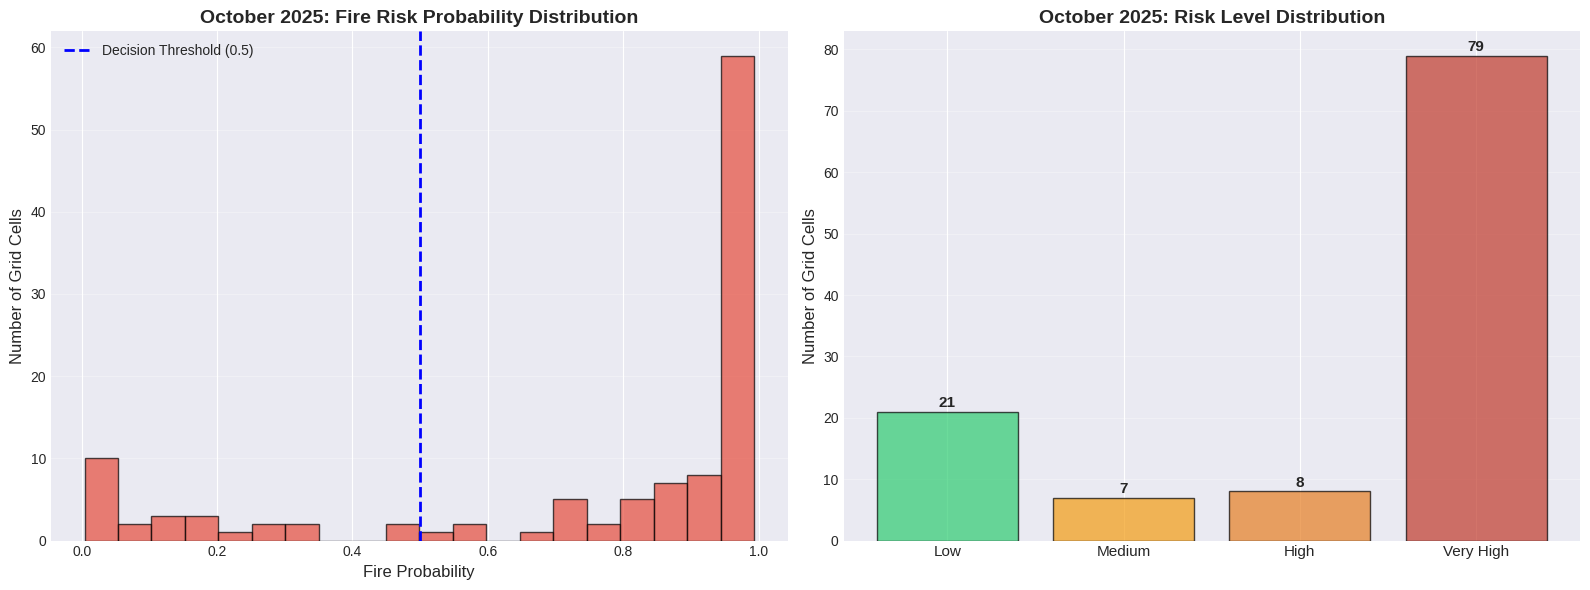

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Probability distribution
ax1 = axes[0]
ax1.hist(oct_2025_predictions['fire_probability'], bins=20, color='#e74c3c', alpha=0.7, edgecolor='black')
ax1.axvline(x=0.5, color='blue', linestyle='--', linewidth=2, label='Decision Threshold (0.5)')
ax1.set_xlabel('Fire Probability', fontsize=12)
ax1.set_ylabel('Number of Grid Cells', fontsize=12)
ax1.set_title('October 2025: Fire Risk Probability Distribution', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# Risk level bar chart
ax2 = axes[1]
risk_counts = oct_2025_predictions['risk_level'].value_counts().sort_index()
colors_risk = ['#2ecc71', '#f39c12', '#e67e22', '#c0392b']
bars = ax2.bar(range(len(risk_counts)), risk_counts.values, color=colors_risk[:len(risk_counts)], alpha=0.7, edgecolor='black')
ax2.set_xticks(range(len(risk_counts)))
ax2.set_xticklabels(risk_counts.index, fontsize=11)
ax2.set_ylabel('Number of Grid Cells', fontsize=12)
ax2.set_title('October 2025: Risk Level Distribution', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, v in enumerate(risk_counts.values):
    ax2.text(i, v + 0.3, str(v), ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

### Visualize spatial risk patterns

In [27]:
# Recreate the grid geometry to visualize spatial risk patterns (or we can save the old grid and reuse them here)

print("Creating spatial grid for visualization...")

# Admin boundaries for Montreal
#admin_bounds = gpd.read_file('Data/EKUE_ASSESSMENTS_DATA/limites-administratives-agglomeration-nad83.geojson')
admin_bounds = gpd.read_file('limites-administratives-agglomeration-nad83 (2).geojson')

admin_bounds['geometry'] = admin_bounds.buffer(0)
admin_bounds = admin_bounds.to_crs(epsg=32188)
boundary_union = unary_union(admin_bounds.geometry)

# Recreate 5km grid (This needs to match whatever we used in preparing data). So, please change the size here to 2.5.
# I used 5km grid just for the POC to reduce computational time.

CELL_SIZE = 2500 #5000  # 5km
BUFFER_SIZE = 500  # 500m buffer
poly = boundary_union.buffer(BUFFER_SIZE)
minx, miny, maxx, maxy = poly.bounds

n_cols = int(np.ceil((maxx - minx) / CELL_SIZE))
n_rows = int(np.ceil((maxy - miny) / CELL_SIZE))

# Create grid cells
cells = []
for r in range(n_rows):
    y1 = miny + r * CELL_SIZE
    y2 = y1 + CELL_SIZE
    for c in range(n_cols):
        x1 = minx + c * CELL_SIZE
        x2 = x1 + CELL_SIZE
        cell = box(x1, y1, x2, y2)
        if cell.intersects(poly):
            cell_id = f"{r}_{c}"
            cells.append({'cell_id': cell_id, 'geometry': cell.intersection(poly)})

# GeoDataFrame
grid_gdf = gpd.GeoDataFrame(cells, crs="EPSG:32188")

# Merge with October 2025 predictions
grid_with_predictions = grid_gdf.merge(
    oct_2025_predictions[['cell_id', 'fire_probability', 'risk_level', 'predicted_fire_risk']],
    on='cell_id',
    how='left'
)

print(f"Grid cells created: {len(grid_gdf)}")
print(f"Cells with predictions: {grid_with_predictions['fire_probability'].notna().sum()}")
print(f"Cells without predictions: {grid_with_predictions['fire_probability'].isna().sum()}")


Creating spatial grid for visualization...
Grid cells created: 142
Cells with predictions: 115
Cells without predictions: 27


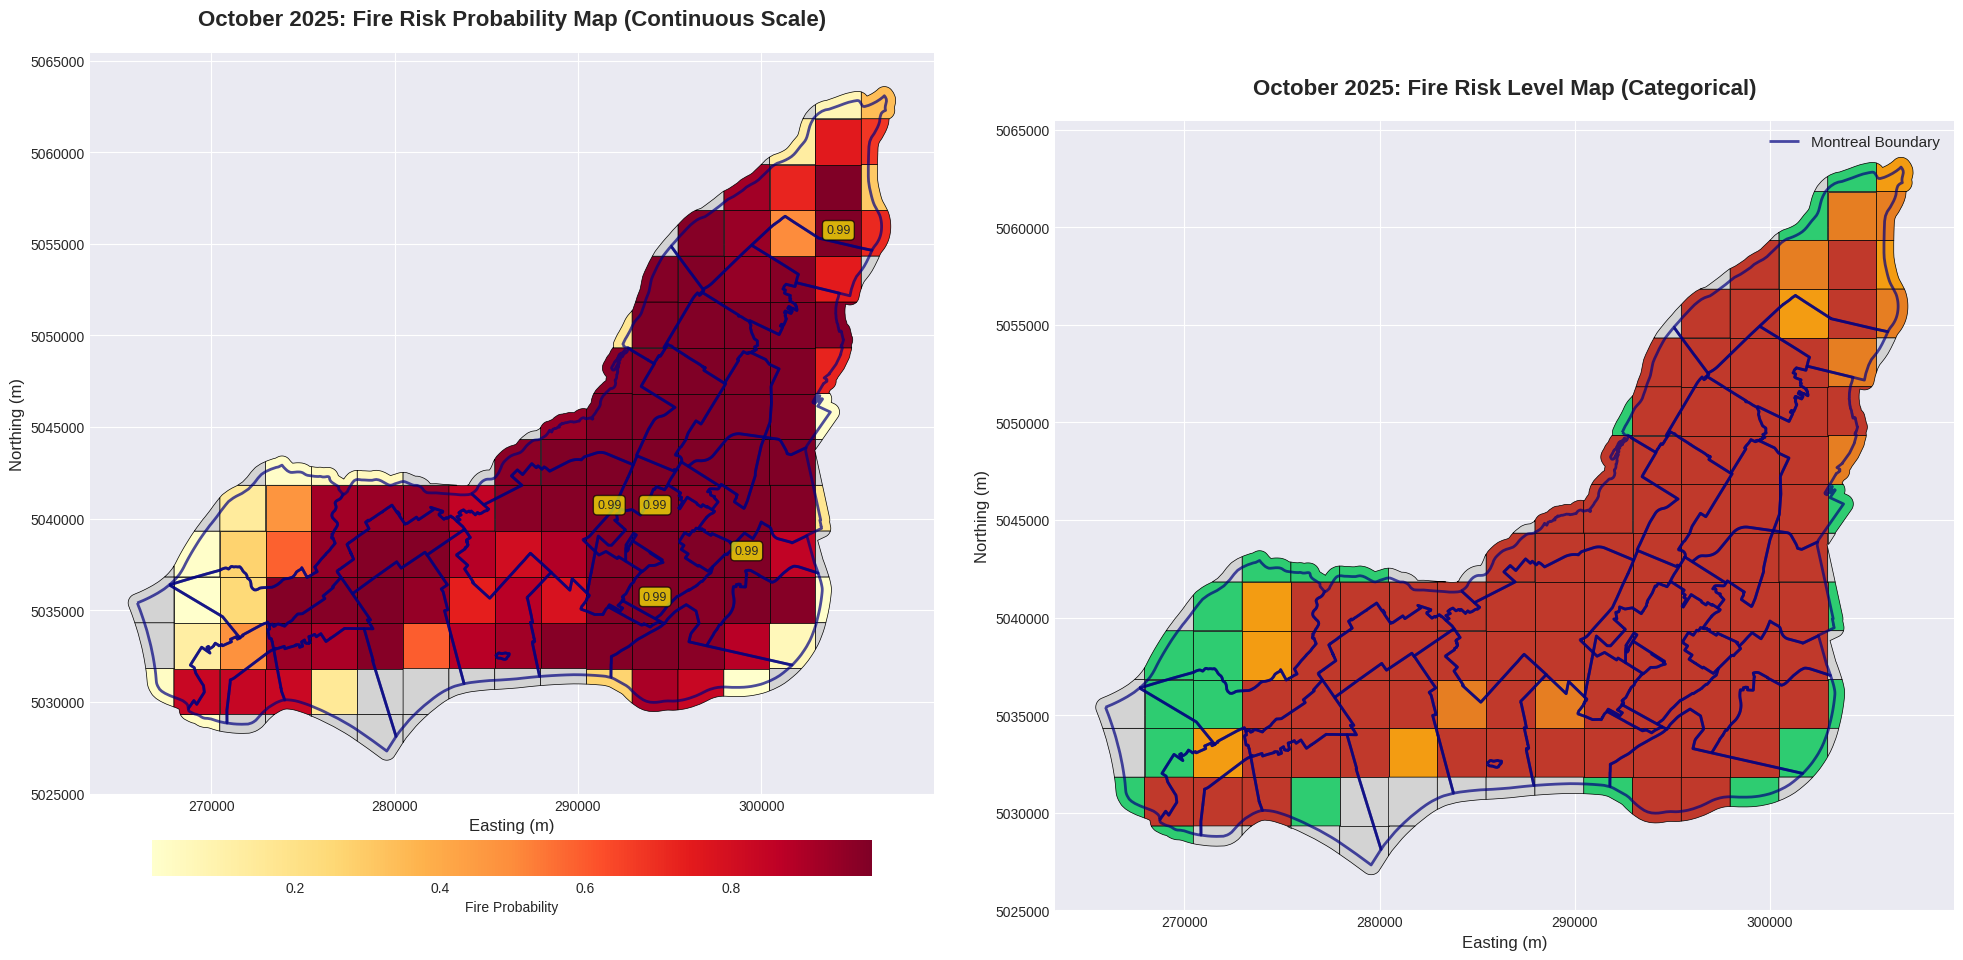


Spatial Distribution Summary:
            Count  Avg Prob  Min Prob  Max Prob
risk_level                                     
Low            21     0.096     0.004     0.272
Medium          7     0.469     0.303     0.593
High            8     0.731     0.678     0.782
Very High      79     0.958     0.807     0.993

Top 5 Highest Risk Cells (Spatial):
cell_id  fire_probability risk_level
  11_15           0.99336  Very High
   3_11           0.99336  Very High
   4_13           0.99336  Very High
   5_10           0.99336  Very High
   5_11           0.99336  Very High


In [28]:

# Spatial map visualization
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# Fire Probability
ax1 = axes[0]
grid_with_predictions.plot(
    column='fire_probability',
    ax=ax1,
    cmap='YlOrRd',
    legend=True,
    edgecolor='black',
    linewidth=0.5,
    missing_kwds={'color': 'lightgrey', 'edgecolor': 'black', 'label': 'No data'},
    legend_kwds={'label': 'Fire Probability', 'orientation': 'horizontal', 'shrink': 0.8, 'pad': 0.05}
)
admin_bounds.boundary.plot(ax=ax1, edgecolor='navy', linewidth=2, alpha=0.7)
ax1.set_title('October 2025: Fire Risk Probability Map (Continuous Scale)',
             fontsize=16, fontweight='bold', pad=20)
ax1.set_xlabel('Easting (m)', fontsize=12)
ax1.set_ylabel('Northing (m)', fontsize=12)
ax1.set_aspect('equal')
ax1.ticklabel_format(style='plain')

# Add text annotations for top 5 risk cells
top_5_cells = oct_2025_predictions.nlargest(5, 'fire_probability')
for idx, row in top_5_cells.iterrows():
    cell_geom = grid_with_predictions[grid_with_predictions['cell_id'] == row['cell_id']].geometry.values
    if len(cell_geom) > 0:
        centroid = cell_geom[0].centroid
        ax1.annotate(
            f"{row['fire_probability']:.2f}",
            xy=(centroid.x, centroid.y),
            fontsize=9,
            ha='center',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7, edgecolor='black')
        )

# Risk Levels
ax2 = axes[1]

# Define color map for risk levels
risk_colors = {
    'Low': '#2ecc71',       # Green
    'Medium': '#f39c12',    # Orange
    'High': '#e67e22',      # Dark Orange
    'Very High': '#c0392b'  # Red
}

# Plot each risk level separately
for risk_level in ['Low', 'Medium', 'High', 'Very High']:
    subset = grid_with_predictions[grid_with_predictions['risk_level'] == risk_level]
    if len(subset) > 0:
        subset.plot(ax=ax2, color=risk_colors[risk_level], edgecolor='black',
                   linewidth=0.5, label=f'{risk_level} ({len(subset)} cells)')

# Plot cells with no data
no_data = grid_with_predictions[grid_with_predictions['risk_level'].isna()]
if len(no_data) > 0:
    no_data.plot(ax=ax2, color='lightgrey', edgecolor='black', linewidth=0.5,
                label=f'No data ({len(no_data)} cells)')

admin_bounds.boundary.plot(ax=ax2, edgecolor='navy', linewidth=2, alpha=0.7, label='Montreal Boundary')
ax2.set_title('October 2025: Fire Risk Level Map (Categorical)',
             fontsize=16, fontweight='bold', pad=20)
ax2.set_xlabel('Easting (m)', fontsize=12)
ax2.set_ylabel('Northing (m)', fontsize=12)
ax2.legend(loc='upper right', fontsize=11, framealpha=0.9)
ax2.set_aspect('equal')
ax2.ticklabel_format(style='plain')

plt.tight_layout()
plt.show()

# Summary statistics by risk level
print("\nSpatial Distribution Summary:")
print("="*60)
risk_summary = oct_2025_predictions.groupby('risk_level').agg({
    'cell_id': 'count',
    'fire_probability': ['mean', 'min', 'max']
}).round(3)
risk_summary.columns = ['Count', 'Avg Prob', 'Min Prob', 'Max Prob']
print(risk_summary)

print("\nTop 5 Highest Risk Cells (Spatial):")
top_cells = oct_2025_predictions.nlargest(5, 'fire_probability')[['cell_id', 'fire_probability', 'risk_level']]
print(top_cells.to_string(index=False))

## Feature Importance Analysis

Feature Importance Rankings (from final Model):
                 feature  importance
           num_buildings    0.192903
            fires_lag_1m    0.183800
            fires_lag_2m    0.133372
            fires_lag_3m    0.104391
            fires_lag_6m    0.101536
           fires_lag_12m    0.071316
           target_lag_1m    0.045912
  neighbors_target_lag1m    0.032631
           target_lag_2m    0.020533
   neighbors_fires_lag1m    0.016396
     neighbors_fires_avg    0.015988
           target_lag_3m    0.015649
          neighbor_count    0.012229
                    year    0.011647
median_construction_year    0.010074
              avg_floors    0.009842
               month_cos    0.008008
                   month    0.007649
               month_sin    0.006123


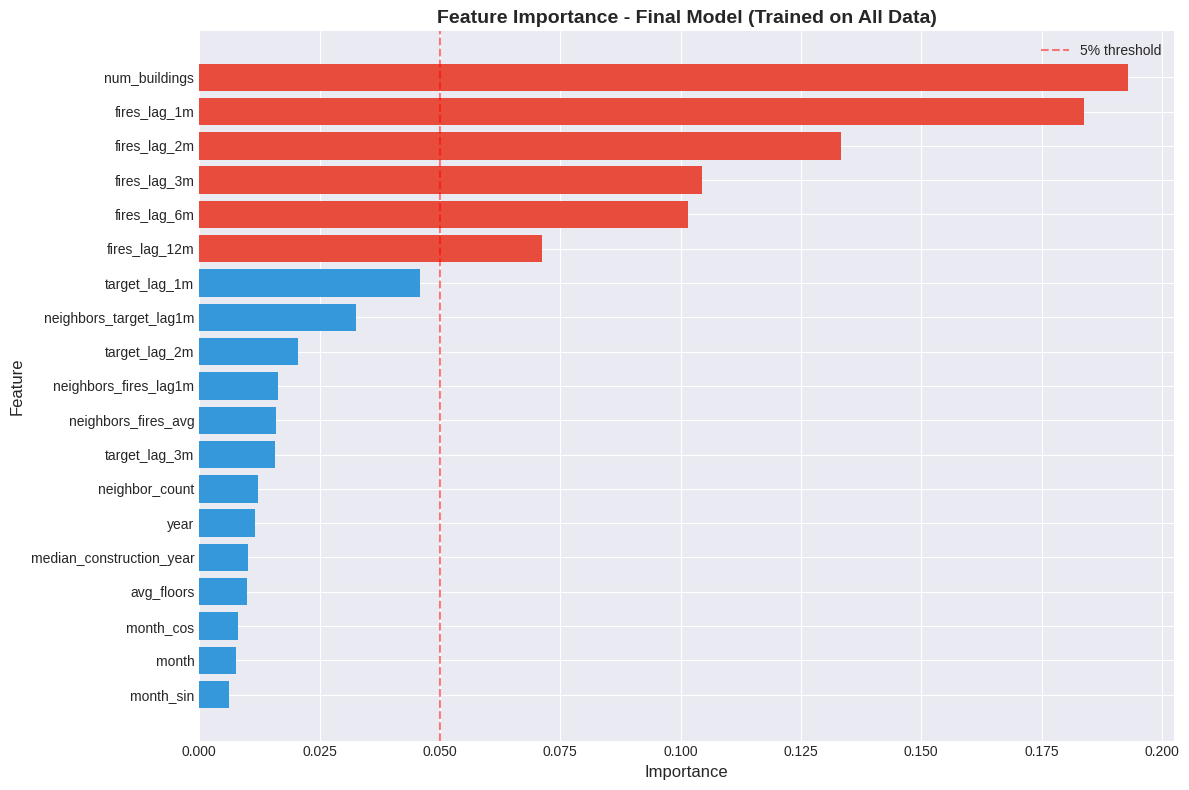

In [29]:
# Feature importance from final model
feature_importance = pd.DataFrame({
    'feature': PREDICTOR_FEATURES,
    'importance': final_model.feature_importances_
}).sort_values('importance', ascending=False)

print("Feature Importance Rankings (from final Model):")
print(feature_importance.to_string(index=False))

# Plot
plt.figure(figsize=(12, 8))
colors = ['#e74c3c' if imp > 0.05 else '#3498db' for imp in feature_importance['importance']]
plt.barh(range(len(feature_importance)), feature_importance['importance'], color=colors)
plt.yticks(range(len(feature_importance)), feature_importance['feature'])
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Feature Importance - Final Model (Trained on All Data)', fontsize=14, fontweight='bold')
plt.axvline(x=0.05, color='red', linestyle='--', alpha=0.5, label='5% threshold')
plt.legend()
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


Importance by Feature Category:
category
Temporal Lag    0.676509
Building        0.212820
Spatial Lag     0.077244
Seasonality     0.033427
Name: importance, dtype: float64


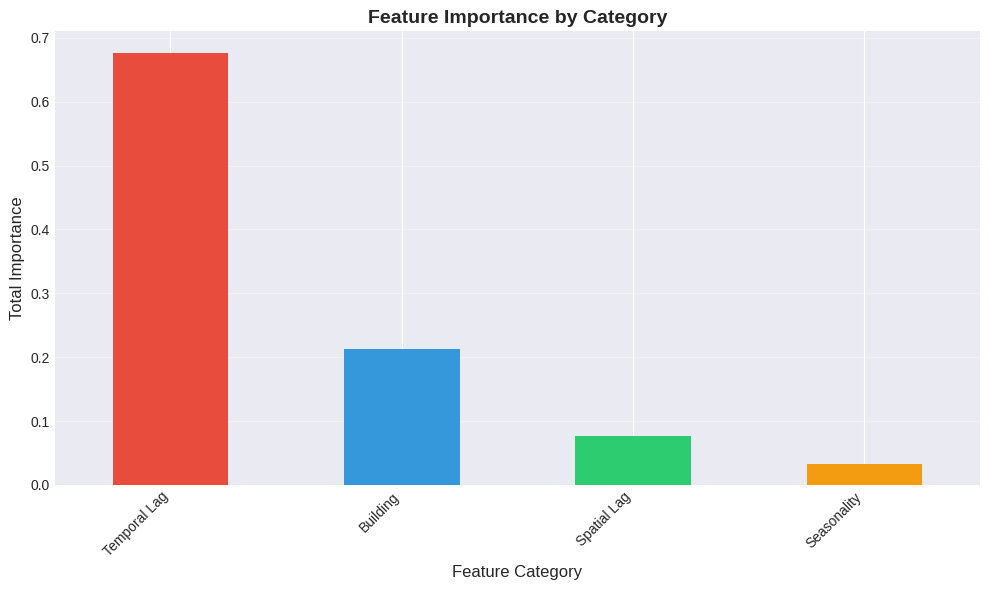

In [30]:
# Feature importance by category
def get_feature_category(feature):
    if feature in BUILDING_FEATURES:
        return 'Building'
    elif feature in TEMPORAL_LAG_FEATURES:
        return 'Temporal Lag'
    elif feature in SEASONALITY_FEATURES:
        return 'Seasonality'
    elif feature in SPATIAL_LAG_FEATURES:
        return 'Spatial Lag'
    return 'Other'

feature_importance['category'] = feature_importance['feature'].apply(get_feature_category)
category_importance = feature_importance.groupby('category')['importance'].sum().sort_values(ascending=False)

print("\nImportance by Feature Category:")
print(category_importance)

# Plot category importance
plt.figure(figsize=(10, 6))
category_importance.plot(kind='bar', color=['#e74c3c', '#3498db', '#2ecc71', '#f39c12'])
plt.title('Feature Importance by Category', fontsize=14, fontweight='bold')
plt.xlabel('Feature Category', fontsize=12)
plt.ylabel('Total Importance', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

## Save Results

In [33]:
# Save ROE metrics
# roe_metrics_path = 'Data/roe_metrics.csv'
roe_metrics_path = 'roe_metrics.csv'

roe_metrics_df.to_csv(roe_metrics_path, index=False)
print(f"ROE metrics saved to: {roe_metrics_path}")

# Save all ROE predictions
all_roe_predictions = pd.concat(roe_predictions, ignore_index=True)

#roe_predictions_path = 'Data/roe_all_predictions.csv'
roe_predictions_path = 'roe_all_predictions.csv'

all_roe_predictions.to_csv(roe_predictions_path, index=False)
print(f"All ROE predictions saved to: {roe_predictions_path}")

# Save October 2025 predictions
#oct_2025_path = 'Data/october_2025_predictions.csv'
oct_2025_path = 'october_2025_predictions.csv'

oct_2025_predictions.to_csv(oct_2025_path, index=False)
print(f"October 2025 predictions saved to: {oct_2025_path}")

# Save final model
#model_path = 'Data/final_rf_model_roe.pkl'
model_path = 'final_rf_model_roe.pkl'

with open(model_path, 'wb') as f:
    pickle.dump(final_model, f)
print(f"Final model saved to: {model_path}")

# Save feature importance
#feature_importance_path = 'Data/feature_importance_roe.csv'
feature_importance_path = 'feature_importance_roe.csv'

feature_importance.to_csv(feature_importance_path, index=False)
print(f"Feature importance saved to: {feature_importance_path}")

print("\nAll results saved successfully!")

ROE metrics saved to: roe_metrics.csv
All ROE predictions saved to: roe_all_predictions.csv
October 2025 predictions saved to: october_2025_predictions.csv
Final model saved to: final_rf_model_roe.pkl
Feature importance saved to: feature_importance_roe.csv

All results saved successfully!


## Summary Report

In [34]:
print("="*80)
print("ROLLING ORIGIN EVALUATION - FINAL SUMMARY REPORT")
print("="*80)

print("\n EVALUATION APPROACH:")
print(f"   - Method: Rolling Origin Evaluation (ROE)")
print(f"   - Number of predictions: {len(roe_metrics_df)}")
print(f"   - Evaluation period: {EVALUATION_START} to {EVALUATION_END}")
print(f"   - Initial training window: {df_clean['year_month'].min()} to {INITIAL_TRAIN_END}")

print("\n HYPERPARAMETER TUNING:")
print(f"   - Tuning period: {TUNE_TRAIN_END} (train) + {TUNE_VAL_START} to {TUNE_VAL_END} (val)")
print(f"   - Method: Randomized Search with 5-fold Time Series CV")
print(f"   - Best parameters: {BEST_PARAMS}")

print("\n OVERALL ROE PERFORMANCE:")
print(f"   - Mean Accuracy: {roe_metrics_df['accuracy'].mean():.4f} ± {roe_metrics_df['accuracy'].std():.4f}")
print(f"   - Mean Balanced Accuracy: {roe_metrics_df['balanced_accuracy'].mean():.4f} ± {roe_metrics_df['balanced_accuracy'].std():.4f}")
print(f"   - Mean Precision: {roe_metrics_df['precision'].mean():.4f} ± {roe_metrics_df['precision'].std():.4f}")
print(f"   - Mean Recall: {roe_metrics_df['recall'].mean():.4f} ± {roe_metrics_df['recall'].std():.4f}")
print(f"   - Mean F1-Score: {roe_metrics_df['f1_score'].mean():.4f} ± {roe_metrics_df['f1_score'].std():.4f}")
print(f"   - Mean ROC-AUC: {roe_metrics_df['roc_auc'].mean():.4f} ± {roe_metrics_df['roc_auc'].std():.4f}")


print("\n" + "="*80)
print("ROLLING ORIGIN EVALUATION COMPLETE")
print("="*80)

ROLLING ORIGIN EVALUATION - FINAL SUMMARY REPORT

 EVALUATION APPROACH:
   - Method: Rolling Origin Evaluation (ROE)
   - Number of predictions: 37
   - Evaluation period: 2022-09 to 2025-09
   - Initial training window: 2005-09 to 2022-08

 HYPERPARAMETER TUNING:
   - Tuning period: 2021-12 (train) + 2022-01 to 2022-12 (val)
   - Method: Randomized Search with 5-fold Time Series CV
   - Best parameters: {'n_estimators': 250, 'min_samples_split': 15, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'max_depth': 15, 'class_weight': 'balanced', 'random_state': 42, 'n_jobs': -1}

 OVERALL ROE PERFORMANCE:
   - Mean Accuracy: 0.9295 ± 0.0185
   - Mean Balanced Accuracy: 0.9239 ± 0.0327
   - Mean Precision: 0.9806 ± 0.0148
   - Mean Recall: 0.9332 ± 0.0158
   - Mean F1-Score: 0.9562 ± 0.0118
   - Mean ROC-AUC: 0.9767 ± 0.0121

ROLLING ORIGIN EVALUATION COMPLETE


In [35]:
print("=" *80)
print("\n OCTOBER 2025 FORECAST:")
print(f"   - Grid cells predicted: {len(oct_2025_predictions)}")
print(f"   - Cells predicted with fire: {oct_2025_predictions['predicted_fire_risk'].sum()}")
print(f"   - Average fire probability: {oct_2025_predictions['fire_probability'].mean():.4f}")
print(f"   - Highest risk cell: {oct_2025_predictions.loc[oct_2025_predictions['fire_probability'].idxmax(), 'cell_id']}")
print(f"   - Highest risk probability: {oct_2025_predictions['fire_probability'].max():.4f}")

print("=" *80 )



 OCTOBER 2025 FORECAST:
   - Grid cells predicted: 115
   - Cells predicted with fire: 90
   - Average fire probability: 0.7548
   - Highest risk cell: 11_15
   - Highest risk probability: 0.9934


In [36]:
print("="*80)
print("\n TOP 5 MOST IMPORTANT FEATURES:")
for i, row in feature_importance.head(5).iterrows():
    print(f"   {row['feature']:30s} {row['importance']:.4f}")

print("="*80)



 TOP 5 MOST IMPORTANT FEATURES:
   num_buildings                  0.1929
   fires_lag_1m                   0.1838
   fires_lag_2m                   0.1334
   fires_lag_3m                   0.1044
   fires_lag_6m                   0.1015


In [37]:
print("="*80)
print("\n MODEL STABILITY:")
cv_coef = roe_metrics_df['f1_score'].std() / roe_metrics_df['f1_score'].mean()
print(f"   - F1-Score coefficient of variation: {cv_coef:.4f}")
if cv_coef < 0.1:
    print(f"   - Assessment: VERY STABLE (CV < 0.1)")
elif cv_coef < 0.2:
    print(f"   - Assessment: STABLE (CV < 0.2)")
else:
    print(f"   - Assessment: MODERATE VARIABILITY (CV >= 0.2)")

print("="*80)



 MODEL STABILITY:
   - F1-Score coefficient of variation: 0.0123
   - Assessment: VERY STABLE (CV < 0.1)


In [38]:
print("="*80)
print("\n FILES GENERATED:")
print(f"   - {roe_metrics_path}")
print(f"   - {roe_predictions_path}")
print(f"   - {oct_2025_path}")
print(f"   - {model_path}")
print(f"   - {feature_importance_path}")

print("="*80)


 FILES GENERATED:
   - roe_metrics.csv
   - roe_all_predictions.csv
   - october_2025_predictions.csv
   - final_rf_model_roe.pkl
   - feature_importance_roe.csv
